### Complejidad - Práctico 2/6 - Movimiento de pájaros 
#### Lautaro Giordano

En este tp vamos a implementar el modelo de Vicsek y a tratar de darle una vuelta de tuerca más.

In [245]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [246]:
# Tamaño del sistema: L x L
# El default es L=5, pero lo voy a variar para estudiar la transición de fase
# con la densidad más abajo

class bird:
    def __init__(self, x, y, angle, velocity):
        self.x = x
        self.y = y
        self.angle = angle
        self.velocity = velocity
        self.vx = self.velocity * np.cos(self.angle)
        self.vy = self.velocity * np.sin(self.angle)

    def move(self, dt):
        self.x += self.vx * dt
        self.y += self.vy * dt
      
    def update_velocity(self):
        self.vx = self.velocity * np.cos(self.angle)
        self.vy = self.velocity * np.sin(self.angle)
        
    
class flock:
    def __init__(self, n, radius=.1, velocity=1, noise_level=0.1, L=5):
        self.birds = [bird(np.random.rand() * L,            # Posicion x inicial
                           np.random.rand() * L,            # Posicion y inicial
                           np.random.rand() * 2*np.pi,      # Angulo inicial
                           velocity) 
                        for _ in range(n)]

        # n es el numero de pajaros
        self.n_birds = n
        # Estos arreglos contienen las posiciones de los pajaros, sirven para calcular
        # las distancias usando funciones de numpy y que el codigo corra mas rapido
        self.x = np.array([b.x for b in self.birds])
        self.y = np.array([b.y for b in self.birds])

        # Radio de interaccion
        self.radius = radius
        self.velocity = velocity
        self.noise_level = noise_level
        # Tamaño del sistema: L x L
        self.L = L
        self.dt = 1
        # Sumo vectorialmente todas las velocidades y calculo el modulo de ese vector
        # Es el parametro de orden que usan en el modelo de Vicsek
        self.average_velocity = [self.update_average_velocity()]
    
    def move(self, dt):
        for b in self.birds:
            b.move(dt)
            # Condiciones de contorno periodicas
            b.x = b.x % self.L
            b.y = b.y % self.L

        self.x = np.array([b.x for b in self.birds])
        self.y = np.array([b.y for b in self.birds])
    
    def update_average_velocity(self):
        v_sum_x = np.sum([b.vx for b in self.birds])
        v_sum_y = np.sum([b.vy for b in self.birds])
        return np.sqrt(v_sum_x**2 + v_sum_y**2) / (self.velocity * self.n_birds)

    def distances(self):
        # Creo una matriz de distancias entre los pajaros
        x_diff = self.x[:, np.newaxis] - self.x[np.newaxis, :]
        y_diff = self.y[:, np.newaxis] - self.y[np.newaxis, :]

        # Distancias con condiciones de contorno periodicas
        dx = np.minimum(np.abs(x_diff), self.L - np.abs(x_diff))
        dy = np.minimum(np.abs(y_diff), self.L - np.abs(y_diff))

        return np.sqrt(dx**2 + dy**2)

    def run_step(self):
        distances = self.distances()
        # Me creo una copia de los angulos para poder actualizarlos todos al mismo tiempo
        new_angles = np.copy([b.angle for b in self.birds])
        for i, bird in enumerate(self.birds):
            v_sum_x = 0
            v_sum_y = 0
            close_birds = 0
            # Para cada pajaro, calculo el promedio de los angulos de los pajaros que estan a una distancia menor al radio
            for j, distance in enumerate(distances[i]):
                if distance < self.radius:
                    v_sum_x += np.cos(self.birds[j].angle)
                    v_sum_y += np.sin(self.birds[j].angle)
                    close_birds += 1

            # Si hay pájaros cercanos, actualizo el ángulo basado en los promedios
            if close_birds > 0:
                new_angles[i] = np.arctan2(v_sum_y, v_sum_x)

        # Ahora que tengo los nuevos angulos, los actualizo en los pajaros
        for i, bird in enumerate(self.birds):
            bird.angle = new_angles[i] + np.random.normal(0, self.noise_level)
            bird.update_velocity()

        # Ahora que todos los angulos y velocidades estan actualizados, muevo los pajaros y actualizo el parametro de orden
        self.move(self.dt)
        self.average_velocity.append(self.update_average_velocity())

    def run(self, steps):
        for _ in range(steps):
            self.run_step()

    def plot(self):
        x = [b.x for b in self.birds]
        y = [b.y for b in self.birds]
        # Ploteo las aves con una pequeña flecha indicando la direccion de 
        # su velocidad (todas del mismo tamaño)
        plt.quiver(x, y, [b.vx for b in self.birds], [b.vy for b in self.birds])
        
    
    # Gracias chatgpt
    def animate(self, steps, interval=100, save_as_gif=False):
        # Create a figure and axis
        fig, ax = plt.subplots()
        ax.set_xlim(0, self.L)
        ax.set_ylim(0, self.L)
        
        # Scatter plot of the birds' positions
        scatter = ax.quiver(
            [b.x for b in self.birds],
            [b.y for b in self.birds],
            [b.vx for b in self.birds],
            [b.vy for b in self.birds]
        )

        # Quito los ejes
        ax.axis('off')
        
        # Update function for the animation
        def update(frame):
            # Run a step of the simulation
            self.run_step()
            
            # Update the scatter plot with new positions and velocities
            scatter.set_offsets(np.c_[[b.x for b in self.birds], [b.y for b in self.birds]])
            scatter.set_UVC([b.vx for b in self.birds], [b.vy for b in self.birds])
            return scatter,

        # Create the animation
        anim = animation.FuncAnimation(
            fig, update, frames=steps, interval=interval, blit=False
        )

        # Save animation as a gif if required
        if save_as_gif:
            anim.save(save_as_gif, writer='imagemagick', fps=30)
        
        plt.show()

Voy a usar tamaño N=100 durante todo el tp, porque la complejidad de la simulación es O(n^2) y aumentar más el tamaño haría que la simulación pase de demorar segundos/minutos a horas.

Hagamos algunas animaciones para ver como se mueven las aves

Ver "flock_animation_r_chico.gif"

MovieWriter imagemagick unavailable; using Pillow instead.


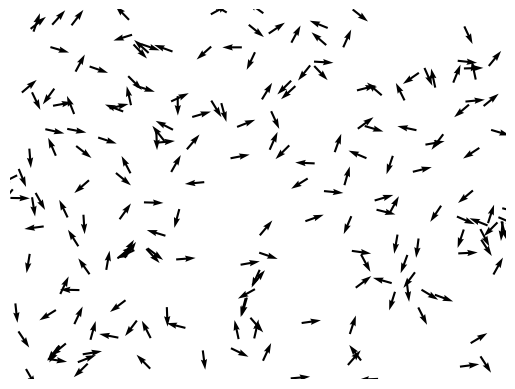

In [247]:
aves = flock(200, radius=.015, velocity=.04, noise_level=.1)
aves.animate(300, interval=300, save_as_gif='flock_animation_r_chico.gif')

Si aumento el radio, se ve la transicion de un comportamiento desordeanado a uno ordenado

Ver "flock_animation_r_grande.gif"

MovieWriter imagemagick unavailable; using Pillow instead.


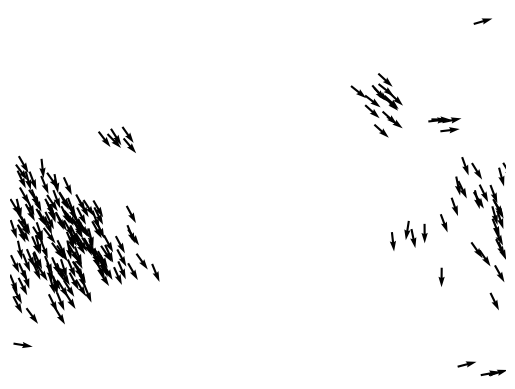

In [248]:
aves = flock(200, radius=.3, velocity=.04, noise_level=.1)
aves.animate(300, interval=300, save_as_gif='flock_animation_r_grande.gif')

Midamos la transicion de fase como hacen en el paper. Estudiemos como cambia la velocidad promedio final de los pajaros en funcion del radio, del ruido y la densidad.

Primero veamos si funciona el calculo de la velocidad promedio final en funcion del radio.

Velocidad promedio ultimos 500 pasos: 0.93


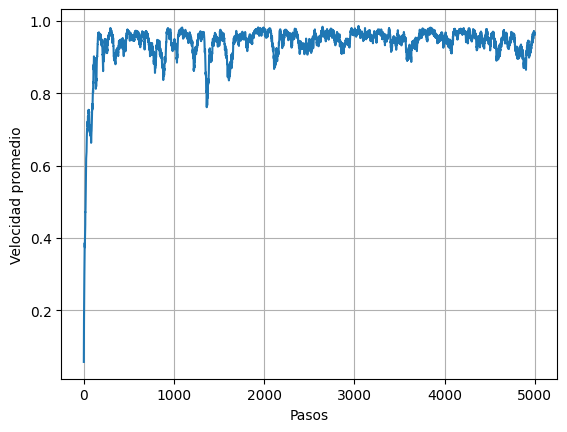

In [249]:
# Le pongo poco ruido
aves = flock(100, radius=.5, velocity=.04, noise_level=0.2)
aves.run(5000)
print(f"Velocidad promedio ultimos 500 pasos: {np.mean(aves.average_velocity[-500:]):.2f}")
plt.plot(aves.average_velocity)
plt.xlabel('Pasos')
plt.ylabel('Velocidad promedio')
plt.grid()

Corramos esto para muchos radios y hacemos un grafico de los promedios finales.

In [250]:
radios = np.linspace(0.05, 1, 30)
velocidades_promedio = []
for i, r in enumerate(radios):
    print(f'Corriendo radios, paso {i+1} de {len(radios)}', end='\r')
    aves = flock(100, radius=r, velocity=.04, noise_level=0.2)
    aves.run(3000)
    velocidades_promedio.append(np.mean(aves.average_velocity[-500:]))

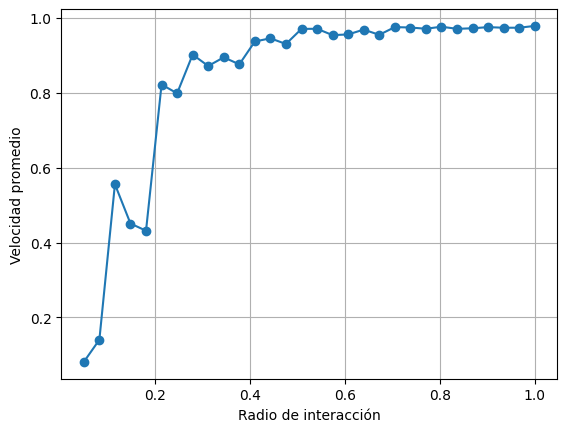

In [251]:
plt.plot(radios, velocidades_promedio, marker='o')
plt.xlabel('Radio de interacción')
plt.ylabel('Velocidad promedio')
plt.grid()

Ahora en funcion del ruido

Velocidad promedio ultimos 500 pasos: 0.8684503608225754


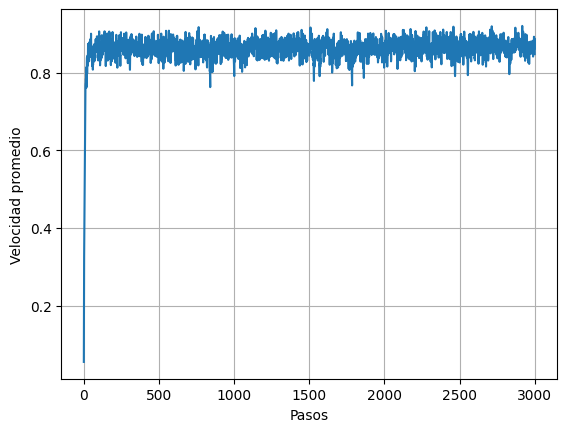

In [267]:
aves = flock(100, radius=1, velocity=.04, noise_level=.5)
aves.run(3000)
print(f"Velocidad promedio ultimos 500 pasos: {np.mean(aves.average_velocity[-500:])}")
plt.plot(aves.average_velocity)
plt.xlabel('Pasos')
plt.ylabel('Velocidad promedio')
plt.grid()

In [268]:
ruidos = np.linspace(0.05, 2, 30)
velocidades_promedio = []
for i, noise in enumerate(ruidos):
    print(f'Corriendo ruidos, paso {i+1} de {len(ruidos)}', end='\r')
    aves = flock(100, radius=1, velocity=.04, noise_level=noise)
    aves.run(3000)
    velocidades_promedio.append(np.mean(aves.average_velocity[-50:]))

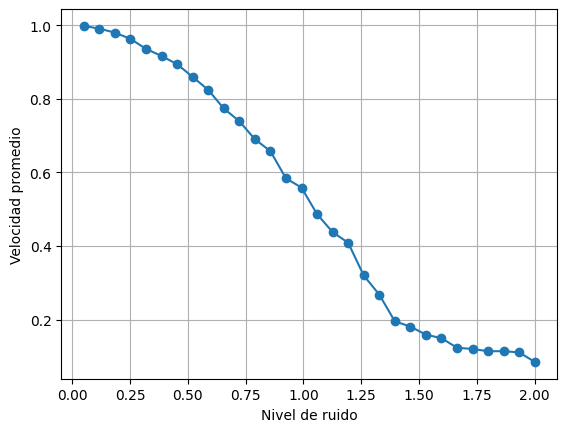

In [269]:
plt.plot(ruidos, velocidades_promedio, marker='o')
plt.xlabel('Nivel de ruido')
plt.ylabel('Velocidad promedio')
plt.grid()

Y en función de la densidad. (Voy a seguir usando N=100 y a cambiar L, quizás N es muy chico pero lo dejo fijo por una cuestión computacional)

In [273]:
densities = np.linspace(.01, 5, 50)
Ls = np.sqrt(100 / densities)
velocidades_promedio = []
for i, L in enumerate(Ls):
    print(f'Corriendo densidades, paso {i+1} de {len(Ls)}', end='\r')
    aves = flock(100, radius=1, velocity=.04, noise_level=0.5, L=L)
    aves.run(3000)
    velocidades_promedio.append(np.mean(aves.average_velocity[-50:]))

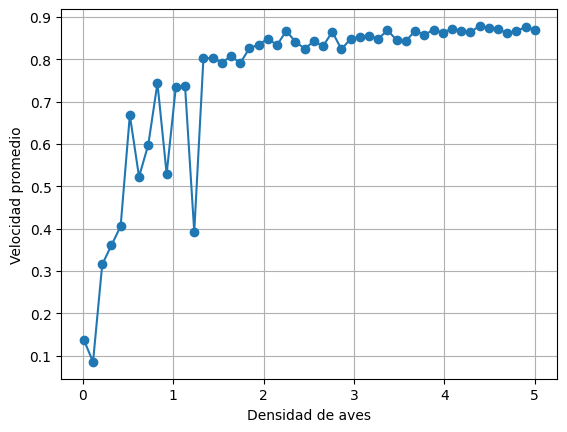

In [274]:
plt.plot(densities, velocidades_promedio, marker='o')
plt.xlabel('Densidad de aves')
plt.ylabel('Velocidad promedio')
plt.grid()

El exponente crítico es 0.39 +- 0.05


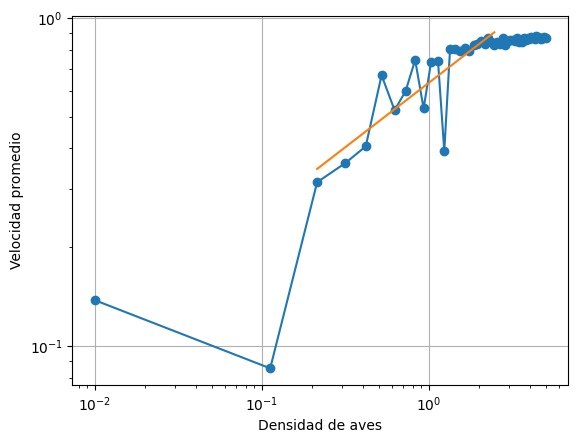

In [286]:
# Estimemos el exponente critico
from scipy.stats import linregress

left = 2
right = -25
densities_fit = densities[left:right]
velocidades_promedio_fit = velocidades_promedio[left:right]
# Hago un ajuste lineal en el logaritmo de los datos
slope, intercept, _, _, std_err = linregress(np.log(densities_fit), np.log(velocidades_promedio_fit))
print(f'El exponente crítico es {slope:.2f} +- {std_err:.2f}')
plt.plot(densities, velocidades_promedio, marker='o', label='Datos')
plt.plot(densities_fit, np.exp(intercept) * densities_fit**slope, label='Ajuste lineal')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Densidad de aves')
plt.ylabel('Velocidad promedio')
plt.grid()
plt.show()


No da tan mal, en el paper reportan que el valor crítico es $\delta = 0.35 \pm 0.06$. Igual probablemente estoy subestimando mi error y para tener una mejor estimación debería aumentar el N.

Acá viene la vuelta de tuerca: Y si pensamos a los pájaros como nodos de un grafo? Si dos pájaros se ven (distancia < r), entonces están conectados. El grafo va a ser dinámico porque los nodos se mueven. Podemos estudiar propiedades como la conectividad del grafo o el clustering y ver si funciona también como parámetro de orden para medir la transición.

Lo que sigue a continuación es una clase que usa la clase anterior de flock y agrega la funcionalidad de crear y actualizar un grafo y medir sus propiedades (para esto vamos a usar la librería Networkx).

In [287]:
import networkx as nx

In [288]:
class vicsek_graph(flock):
    def __init__(self, n, radius=0.1, velocity=1, noise_level=0.1, L=5):
        super().__init__(n, radius, velocity, noise_level, L)
        # El grafo va a ser de tipo networkx graph
        self.graph = nx.Graph()
        self.graph.add_nodes_from(range(n))
        # Propiedades del grafo como listas
        self.mean_degree = []
        self.clustering = []
        self.giant_component = []
        self.build_graph()
        self.update_properties()

    def build_graph(self):
        # Funcion que crea el grafo de networkx (también se usa a cada paso para actualizarlo)
        self.graph.clear_edges()
        edges = []
        distances = self.distances()
        for i, bird in enumerate(self.birds):
            for j, distance in enumerate(distances[i]):
                if distance < self.radius and i != j:
                    edges.append((i, j))
        self.graph.add_edges_from(edges)
 
    def update_properties(self):
        # Calcula las propiedades del grafo y las guarda en las listas
        self.mean_degree.append(np.mean(list(dict(self.graph.degree()).values())))
        self.clustering.append(nx.average_clustering(self.graph))
        self.giant_component.append(len(max(nx.connected_components(self.graph), key=len)) / self.n_birds)

    def run_step(self):
        # Corre un paso del modelo de Vicsek y luego actualiza el grafo y sus propiedades
        super().run_step()
        self.build_graph()
        self.update_properties()

    def run(self, steps):
        # Corre el modelo de Vicsek por una cantidad de pasos
        for _ in range(steps):
            self.run_step()

    def plot_graph(self):
        # Plotea el grafo
        nx.draw(self.graph, pos={i: (b.x, b.y) for i, b in enumerate(self.birds)}, node_size=20, width=0.5)

Genero un grafo de Vicsek y lo ploteo. No se ve muy lindo por las conexiones que se generan por las condiciones periódicas, pero es un grafo al fin.

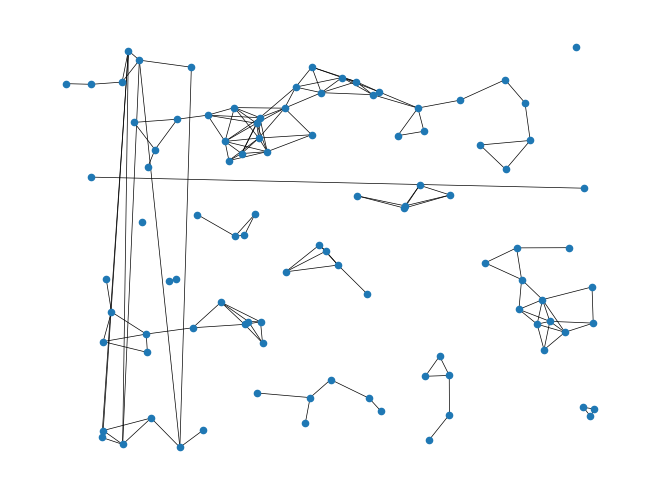

In [289]:
graph_model = vicsek_graph(100, radius=.5, velocity=0.04, noise_level=0.1, L=5)
graph_model.plot_graph()

A t=0 el grafo está bastante desconectado y pocas aves se pueden ver.

Corramos algunos pasos de la simulación y veamos como cambia el grafo.

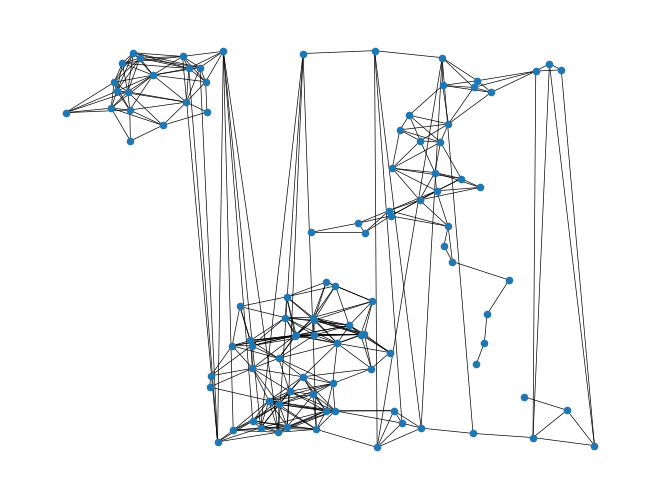

In [260]:
for _ in range(500):
    graph_model.run_step()
graph_model.plot_graph()

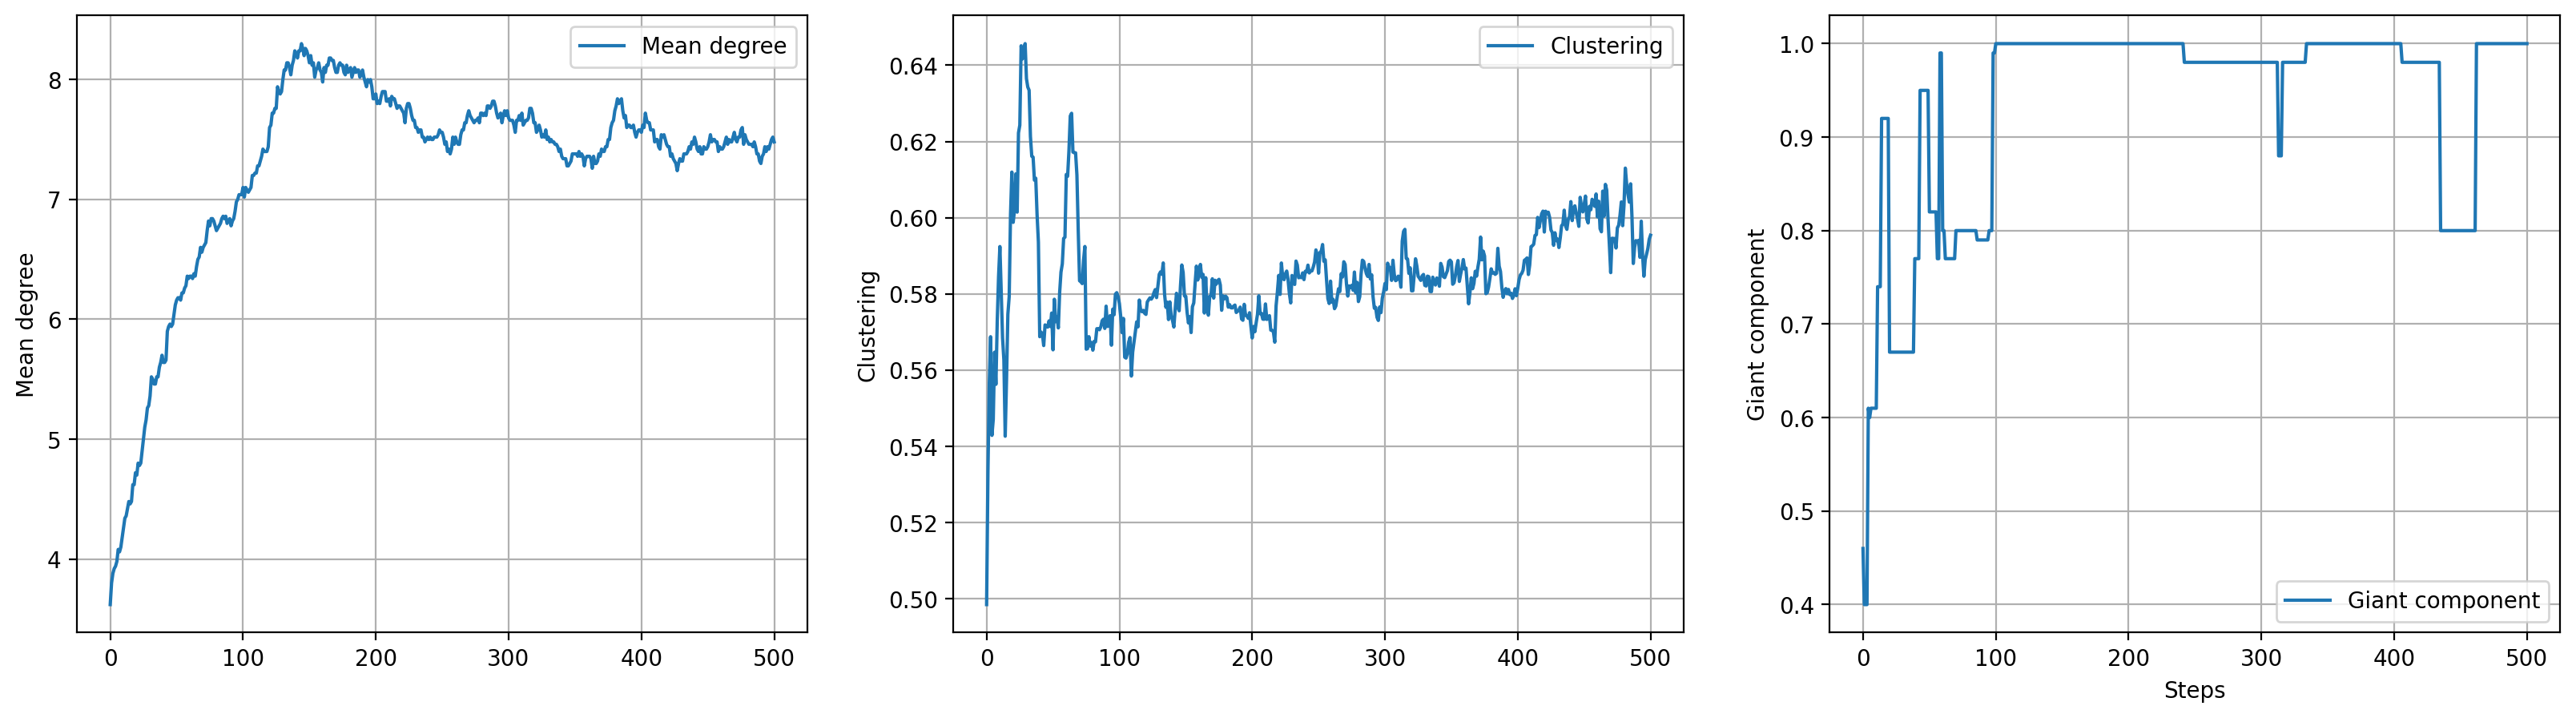

In [261]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5), dpi=200)
ax[0].plot(graph_model.mean_degree, label='Mean degree')
ax[0].set_ylabel('Mean degree')
ax[1].plot(graph_model.clustering, label='Clustering')
ax[1].set_ylabel('Clustering')
ax[2].plot(graph_model.giant_component, label='Giant component')
ax[2].set_ylabel('Giant component')
ax[2].set_xlabel('Steps')
for a in ax:
    a.grid()
    a.legend()

Veamos como se modifican el grado medio y clustering finales en función del radio y del ruido.

In [262]:
radios = np.linspace(0.05, 1, 30)
mean_degrees = []
clustering = []
giant_components = []

for i, r in enumerate(radios):
    print(f'Corriendo grafos-radios, paso {i+1} de {len(radios)}', end='\r')
    graph_model = vicsek_graph(100, radius=r, velocity=0.04, noise_level=0.1)
    graph_model.run(3000)
    mean_degrees.append(np.mean(graph_model.mean_degree[-500:]))
    clustering.append(np.mean(graph_model.clustering[-500:]))
    giant_components.append(np.mean(graph_model.giant_component[-500:]))

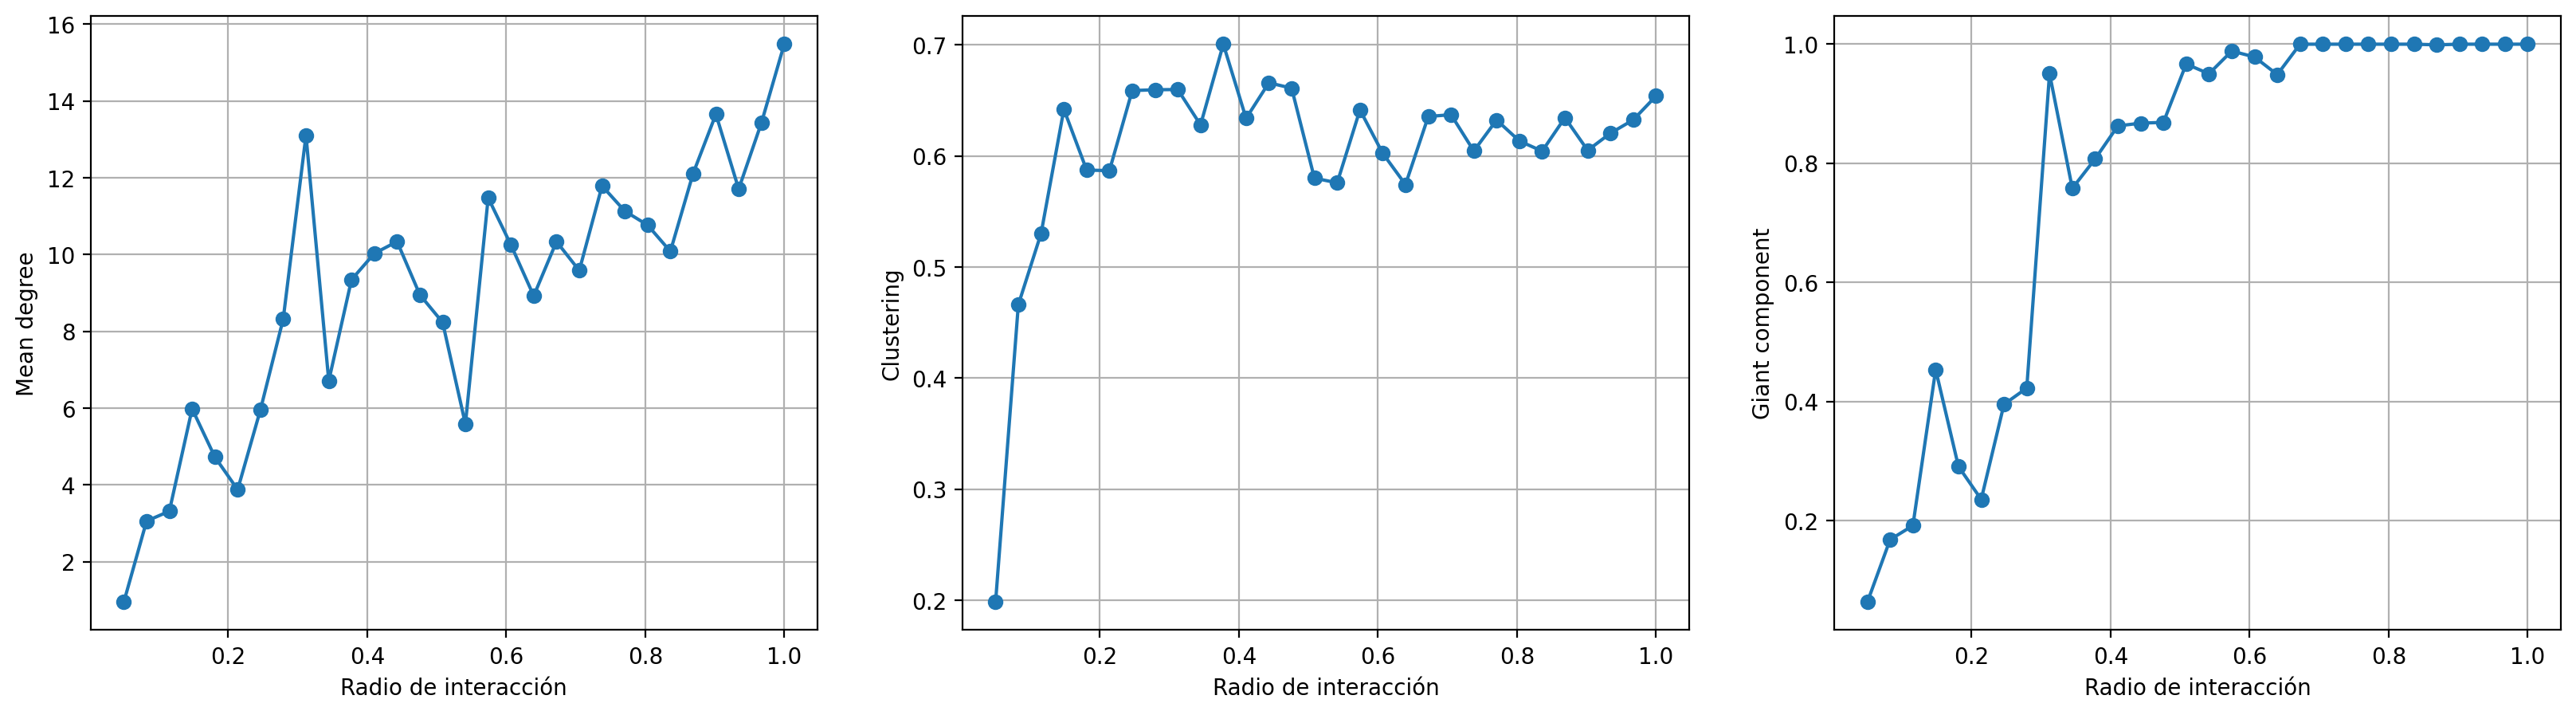

In [263]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5), dpi=200)
ax[0].plot(radios, mean_degrees, marker='o')
ax[0].set_ylabel('Mean degree')
ax[1].plot(radios, clustering, marker='o')
ax[1].set_ylabel('Clustering')
ax[2].plot(radios, giant_components, marker='o')
ax[2].set_ylabel('Giant component')
ax[2].set_xlabel('Radius')
for a in ax:
    a.set_xlabel('Radio de interacción')
    a.grid()

Lo mismo en función del ruido

In [290]:
ruidos = np.linspace(0.05, 2, 30)
mean_degrees = []
clustering = []
giant_components = []

for i, noise in enumerate(ruidos):
    print(f'Corriendo grafos-ruidos, paso {i+1} de {len(ruidos)}', end='\r')
    graph_model = vicsek_graph(100, radius=1, velocity=.04, noise_level=noise)
    aves.run(3000)
    mean_degrees.append(np.mean(graph_model.mean_degree[-50:]))
    clustering.append(np.mean(graph_model.clustering[-50:]))
    giant_components.append(np.mean(graph_model.giant_component[-50:]))

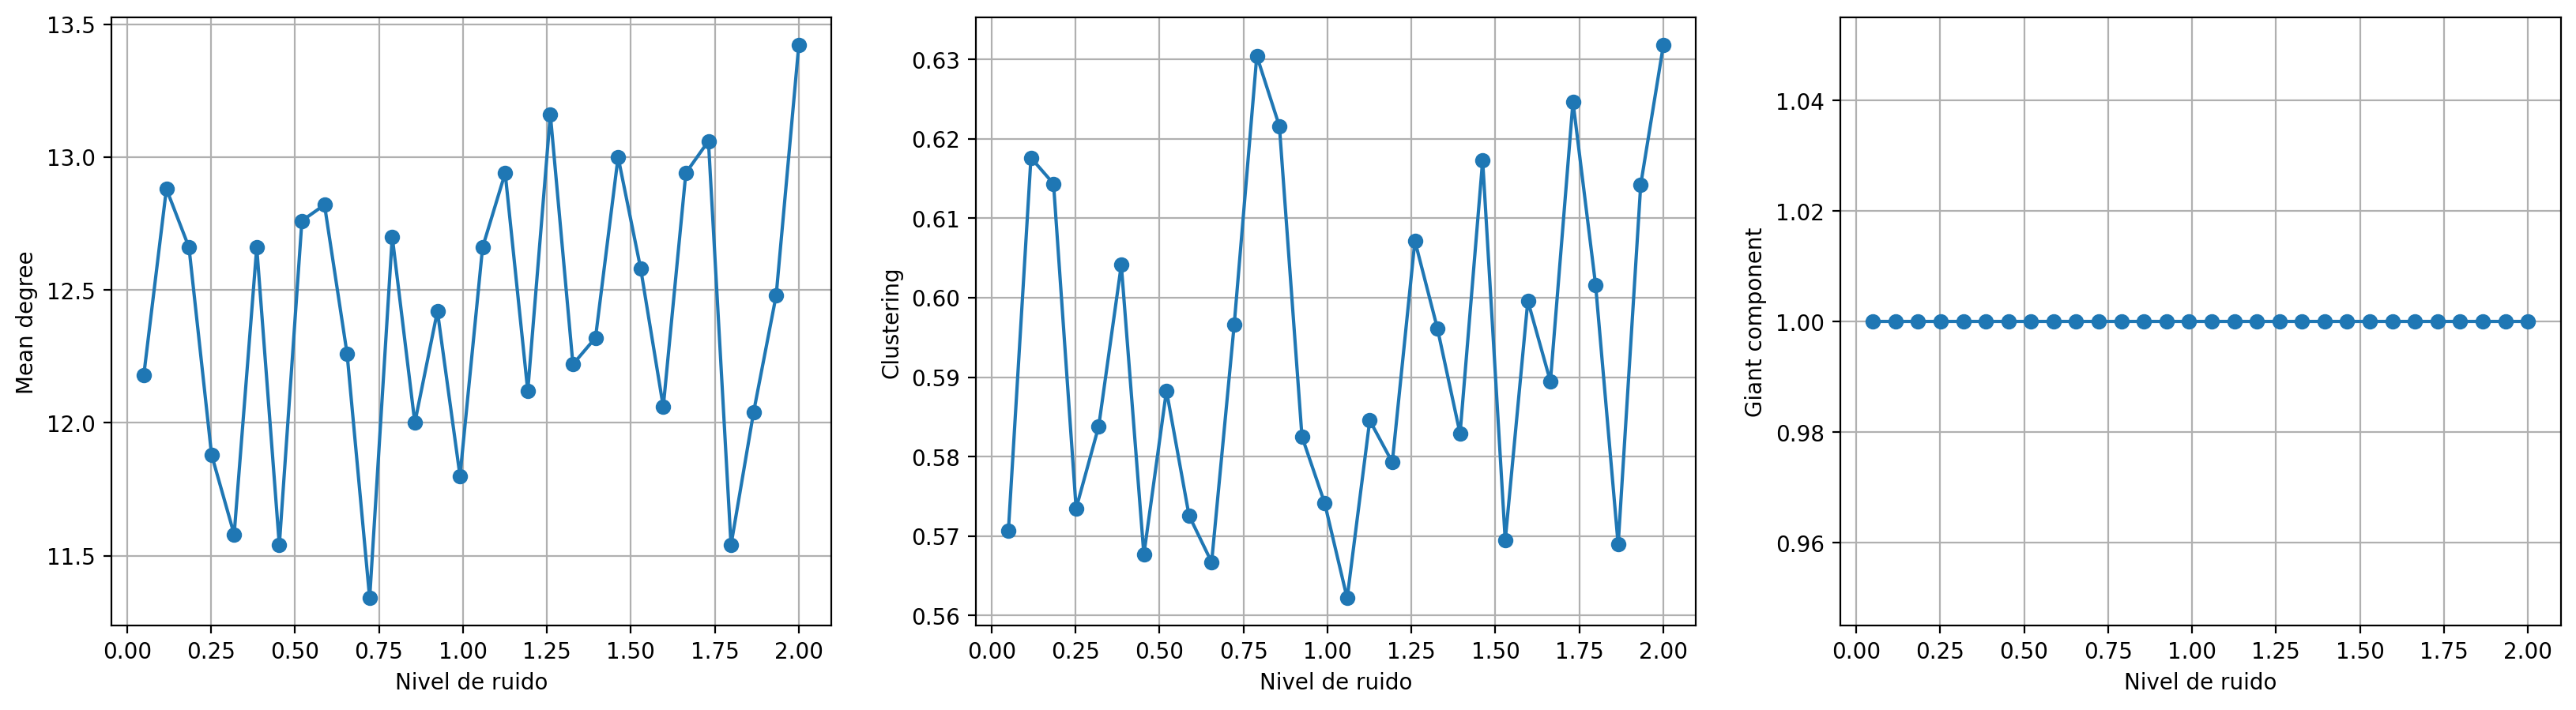

In [293]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5), dpi=200)
ax[0].plot(ruidos, mean_degrees, marker='o')
ax[0].set_ylabel('Mean degree')
ax[1].plot(ruidos, clustering, marker='o')
ax[1].set_ylabel('Clustering')
ax[2].plot(ruidos, giant_components, marker='o')
ax[2].set_ylabel('Giant component')
ax[2].set_xlabel('Noise level')
for a in ax:
    a.set_xlabel('Nivel de ruido')
    a.grid()

Y en función de la densidad

In [304]:
densities = np.linspace(.005, 3, 50)
Ls = np.sqrt(100 / densities)
mean_degrees = []
clustering = []
giant_components = []

for i, L in enumerate(Ls):
    print(f'Corriendo grafos-densidades, paso {i+1} de {len(Ls)}', end='\r')
    graph_model = vicsek_graph(100, radius=1, velocity=.04, noise_level=0.5, L=L)
    graph_model.run(3000)
    mean_degrees.append(np.mean(graph_model.mean_degree[-50:]))
    clustering.append(np.mean(graph_model.clustering[-50:]))
    giant_components.append(np.mean(graph_model.giant_component[-50:]))

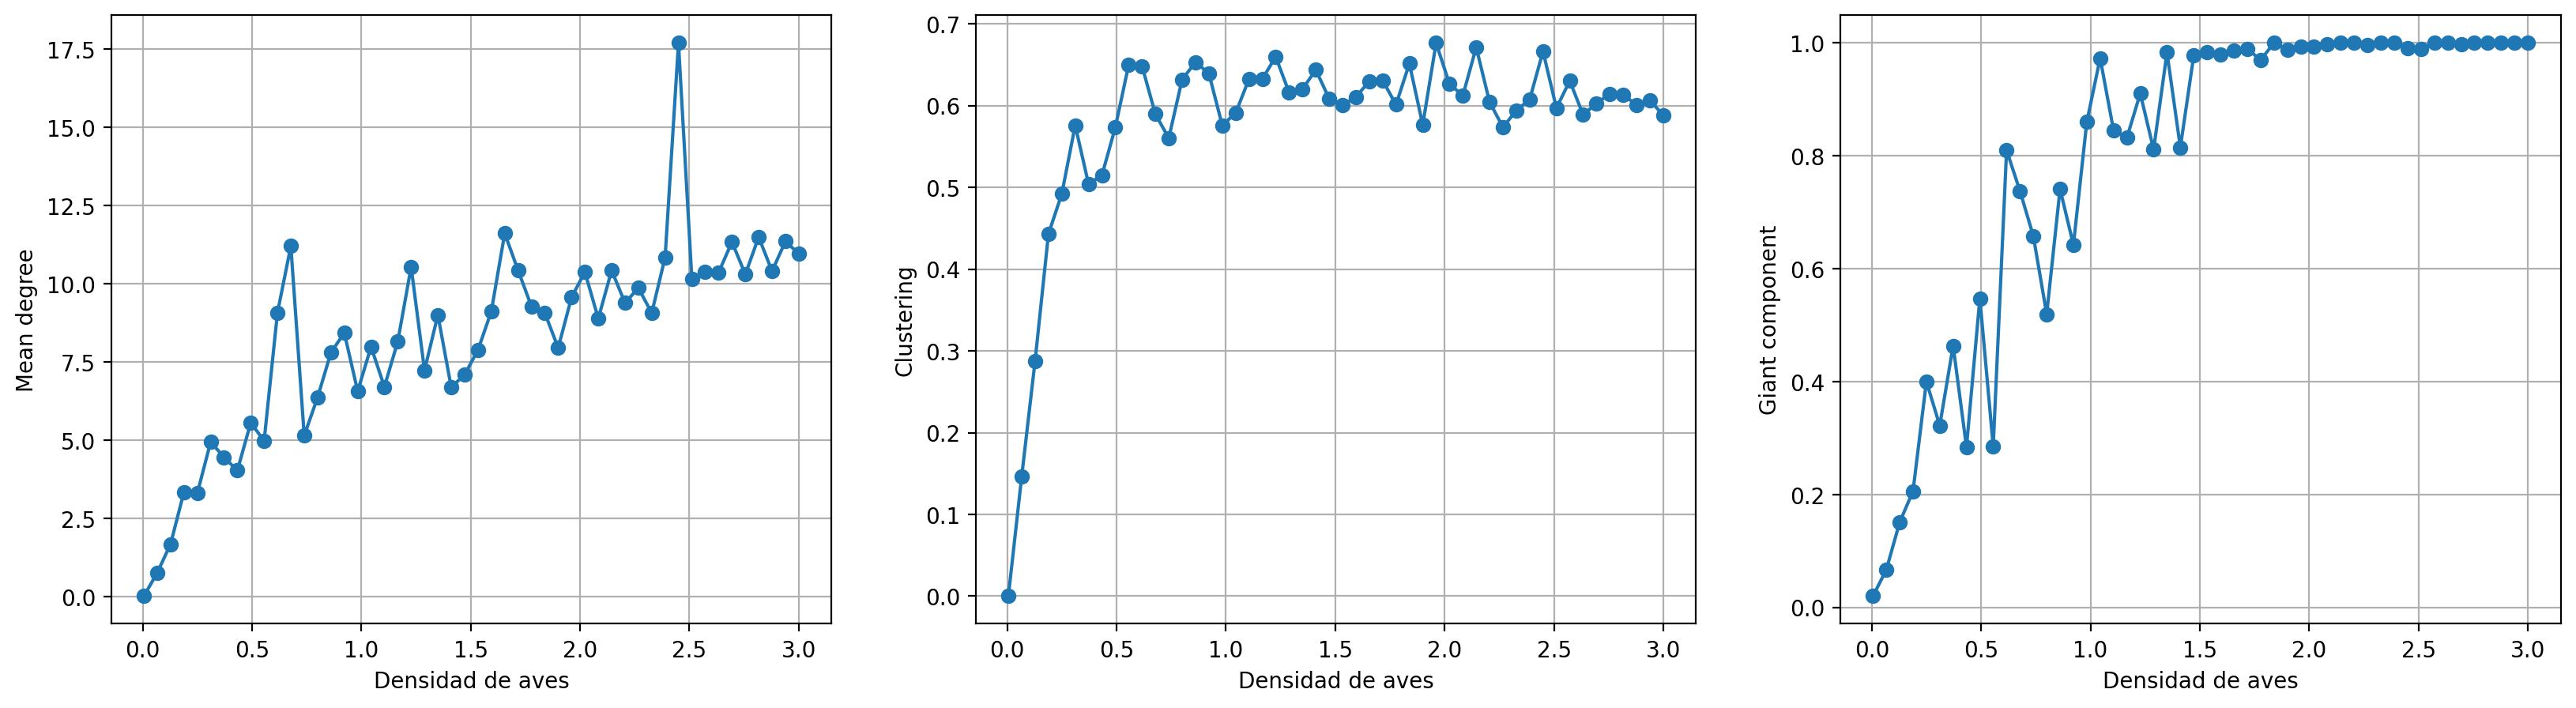

In [305]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5), dpi=200)
ax[0].plot(densities, mean_degrees, marker='o')
ax[0].set_ylabel('Mean degree')
ax[1].plot(densities, clustering, marker='o')
ax[1].set_ylabel('Clustering')
ax[2].plot(densities, giant_components, marker='o')
ax[2].set_ylabel('Giant component')
ax[2].set_xlabel('Density')

for a in ax:
    a.set_xlabel('Densidad de aves')
    a.grid()

Podre estimar un comportamiento crítico en función del tamaño de la componente gigante? Parece un poco tirado de los pelos, pero si uno piensa en la transición de fase de un sistema de percolación, la componente gigante es un buen parámetro de orden.

El exponente crítico es 0.76 +- 0.10


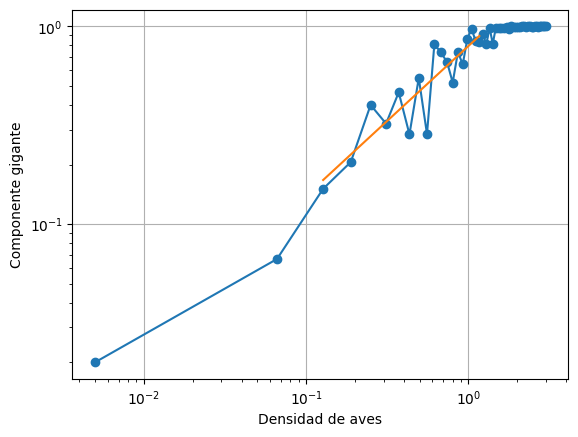

In [311]:
left = 2
right = -30
densities_fit = densities[left:right]
giant_components_fit = giant_components[left:right]
slope, intercept, _, _, std_err = linregress(np.log(densities_fit), np.log(giant_components_fit))
print(f'El exponente crítico es {slope:.2f} +- {std_err:.2f}')
plt.plot(densities, giant_components, marker='o', label='Datos')
plt.plot(densities_fit, np.exp(intercept) * densities_fit**slope, label='Ajuste lineal')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Densidad de aves')
plt.ylabel('Componente gigante')
plt.grid()